Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре). 
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [1]:
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

import pymorphy3
morph = pymorphy3.MorphAnalyzer()

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
# torch.set_default_device('cpu')

import keras
print(keras.__version__)

3.8.0


In [31]:
import codecs
file = codecs.open('wiki_data.txt', "r", "utf-8" )
wiki = file.read().split('\n')

In [10]:
cv = CountVectorizer(max_features=10000)
svd = TruncatedSVD(200)

X = cv.fit_transform(wiki)
X_svd = svd.fit_transform(X)

embeddings = svd.components_.T

In [11]:
id2word = cv.get_feature_names_out()
word2id = {word:i for i,word in enumerate(id2word)}

In [4]:
import re
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [morph.parse(token)[0] for token in tokens]
    tokens = [token.normal_form for token in tokens]
    return tokens

In [5]:
from tqdm import tqdm

In [13]:
vocab = Counter()

for text in tqdm(wiki):
    vocab.update(preprocess(text))

100%|██████████| 20003/20003 [05:40<00:00, 58.80it/s] 


In [14]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [15]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [16]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [17]:
vocab_size = len(id2word)

In [18]:
# skip gram
def gen_batches_sg(sentences, window = 3, batch_size=1000):
    
    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

# # cbow 
def gen_batches_cbow(sentences, window = 3, batch_size=1000):
    
    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [18]:
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(1,))


embeddings_target = keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Flatten()(embeddings_context)

dot = keras.layers.Dot(1)([target, context])
outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
model.fit(gen_batches_sg(sentences[:19000]),
          validation_data=gen_batches_sg(sentences[19000:]),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
          epochs=20)

Epoch 1/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 318s 32ms/step - accuracy: 0.7921 - loss: 0.4546 - val_accuracy: 0.8361 - val_loss: 0.3890
Epoch 2/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 253s 25ms/step - accuracy: 0.8420 - loss: 0.3689 - val_accuracy: 0.8491 - val_loss: 0.3549
Epoch 3/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 282s 28ms/step - accuracy: 0.8544 - loss: 0.3386 - val_accuracy: 0.8559 - val_loss: 0.3380
Epoch 4/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 377s 38ms/step - accuracy: 0.8601 - loss: 0.3251 - val_accuracy: 0.8502 - val_loss: 0.3551
Epoch 5/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 339s 34ms/step - accuracy: 0.8635 - loss: 0.3148 - val_accuracy: 0.8577 - val_loss: 0.3395
Epoch 6/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 223s 22ms/step - accuracy: 0.8709 - loss: 0.2980 - val_accuracy: 0.8402 - val_loss: 0.3820
Epoch 7/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 199s 20ms/step - accuracy: 0.8739 - loss: 0.2912 - val_accuracy: 0.8390 - val_loss: 0.3867
Epoch 8/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 305s 31ms/s

In [14]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:5]]
    return similar
#сделала топ 5 вместо топ 10 для удобства

In [21]:
embeddings = model.layers[2].get_weights()[0]

In [22]:
print (most_similar('жизнь', embeddings), most_similar('боль', embeddings))

['жизнь', 'благосостояние', 'страдание', 'процветание', 'покойный'] ['боль', 'мышечный', 'зуд', 'синдром', 'аллергический']


In [15]:
#cbow negative sampling
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(20,))


embeddings_target = keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Lambda(lambda x: x.sum(axis=1))(embeddings_context)
dot = keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
model.build([(None, 1), (None, 20)])
model.fit(gen_batches_cbow(sentences[:19000], window=20),
          validation_data=gen_batches_cbow(sentences[19000:],  window=20),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
          epochs=20)

Epoch 1/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 115s 23ms/step - accuracy: 0.8233 - loss: 0.3965 - val_accuracy: 0.8813 - val_loss: 0.2930
Epoch 2/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 117s 23ms/step - accuracy: 0.8852 - loss: 0.2822 - val_accuracy: 0.8981 - val_loss: 0.2555
Epoch 3/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 117s 23ms/step - accuracy: 0.9104 - loss: 0.2224 - val_accuracy: 0.8936 - val_loss: 0.2665
Epoch 4/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 116s 23ms/step - accuracy: 0.9194 - loss: 0.2030 - val_accuracy: 0.8975 - val_loss: 0.2664
Epoch 5/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 116s 23ms/step - accuracy: 0.9311 - loss: 0.1778 - val_accuracy: 0.8986 - val_loss: 0.2777
Epoch 6/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 115s 23ms/step - accuracy: 0.9415 - loss: 0.1550 - val_accuracy: 0.8760 - val_loss: 0.3807
Epoch 7/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 115s 23ms/step - accuracy: 0.9453 - loss: 0.1482 - val_accuracy: 0.8864 - val_loss: 0.3548
Epoch 8/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 115s 23ms/step - accuracy: 

In [17]:
embeddings = model.layers[2].get_weights()[0]

In [24]:
print(most_similar('мир', embeddings), most_similar('жизнь', embeddings), sep='\n')

['мир', 'европа', 'история', 'чемпионат', 'турнир']
['жизнь', 'смерть', 'забота', 'общество', 'не']


# Задание 2 (2 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [27]:
!pip install gensim

In [28]:
import gensim

In [32]:
texts = [preprocess(text) for text in wiki]

In [33]:
%%time
w2v = gensim.models.Word2Vec(texts, )

CPU times: total: 5.72 s
Wall time: 8.27 s


In [34]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             vector_size=220, 
                             min_count=42, 
                             max_vocab_size=9000,
                             window=7,
                             epochs=6,
                             sample=1e-4,
                             hs=0,
                             negative=7,
                             sg=1,
                             ns_exponent=0.7)

CPU times: total: 14.2 s
Wall time: 27.9 s


In [39]:
w2v.wv.most_similar('жизнь')

[('любовь', 0.5137007832527161),
 ('мысль', 0.48829516768455505),
 ('писать', 0.48748597502708435),
 ('судьба', 0.46646174788475037),
 ('смерть', 0.46003371477127075),
 ('творчество', 0.43642449378967285),
 ('образ', 0.4345947206020355),
 ('весь', 0.434222012758255),
 ('сам', 0.43247854709625244),
 ('тема', 0.4323006570339203)]

In [40]:
%%time
ft = gensim.models.FastText(texts)

CPU times: total: 30.2 s
Wall time: 38.1 s


In [41]:
%%time
ft = gensim.models.FastText(texts, min_n=5, max_n=10)

CPU times: total: 31.9 s
Wall time: 32.9 s


In [42]:
ft.wv.most_similar('жизнь')

[('жизнью»', 0.9892975091934204),
 ('alkan', 0.9850301742553711),
 ('жизнь»', 0.9648974537849426),
 ('«жизнь', 0.9555759429931641),
 ('жизни»', 0.8117483854293823),
 ('жизненно', 0.7297841906547546),
 ('«судьба', 0.6842685341835022),
 ('детство', 0.6823813319206238),
 ('«детство', 0.6570226550102234),
 ('сознание', 0.656275749206543)]

# Задание 3 (3 балла)

Используя датасет для классификации (labeled.csv), обучите классификатор на базе эмбеддингов. Оцените качество на отложенной выборке.   
В качестве эмбеддинг модели вы можете использовать одну из моделей обученных в предыдущем задании или использовать одну из предобученных моделей с rusvectores (удостоверьтесь что правильно воспроизводите предобработку в этом случае!)  
Для того, чтобы построить эмбединг целого текста, усредните вектора отдельных слов в один общий вектор. 
В качестве алгоритма классификации используйте LogisicticRegression (можете попробовать SGDClassifier, чтобы было побыстрее)  
F1 мера должна быть выше 20%. 

In [74]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression as logreg

In [6]:
data = pd.read_csv('labeled.csv')
data['norm_text'] = data.comment.apply(preprocess)

In [7]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6308

In [70]:
def word_toid(tokens):
    vec = np.zeros(w2v.vector_size)
    for token in tokens:
        if token in w2v.wv:
            vec+=w2v.wv[token]

    return vec

In [71]:
X = [word_toid(text) for text in data['norm_text']]

In [72]:
y = data.toxic.values

In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [75]:
clf = logreg(penalty='l2', class_weight= 'balanced', max_iter= 10000)
clf.fit(X_train, y_train)
preds = clf.predict(X_valid)
print(classification_report(y_valid, preds, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.92      0.70      0.79       493
         1.0       0.57      0.86      0.69       228

    accuracy                           0.75       721
   macro avg       0.74      0.78      0.74       721
weighted avg       0.81      0.75      0.76       721



In [76]:
preds_proba = clf.predict_proba(X_valid)

In [81]:
counter = Counter({comm: prob[1] for comm, prob in zip(data.comment, preds_proba)})
counter.most_common(10)

[('Ты, как совместившая, делишься опытом? Учту.\n', 0.9999104553209482),
 ('Ну хочешь я стану твоим другом? Как тебя зовут? Чем увлекаешься?\n',
  0.9995722744880517),
 ('Я тоже. Ладно мы, у нас еще сто лет назад власть захватил открыто антирусский режим. Мордор он и есть Мордор. Но у них-то еще совсем недавно все было хорошо и никто бы не мог даже представить такого пиздеца.\n',
  0.9992684276337245),
 ('Ну давай. Отбери у меня нож, клоун, только я махну рукой и твои яйца разлетятся по всему арбату.\n',
  0.9983425860993097),
 ('Просто ник автора, наверное\n', 0.9952993285835451),
 ('Большинство новых коттеджных поселков имеют статус садоводств, благодаря этому могут еще и сдирать по три шкуры с новых собственников на обслуживании. Причем сейчас с кризисом в загородке очень много стали продавать без подряда. У нас очень неразвита строительная экспертиза и контроль в частном домостроении, поэтому проблемных домов очень много, где люди потом годами пытаются это исправить.\n',
  0.995005

# Задание 4 (2 доп балла)

В тетрадку с фастекстом добавьте код для обучения с negative sampling (задача сводится к бинарной классификации) и обучите модель. Проверьте полученную модель на нескольких словах. Похожие слова должны быть похожими по смыслу и по форме.

In [84]:
import re
from collections import Counter
def tokenize(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [85]:
def ngrammer(raw_string, n=2):
    ngrams = []
    raw_string = ''.join(['<', raw_string, '>'])
    for i in range(0,len(raw_string)-n+1):
        ngram = ''.join(raw_string[i:i+n])
        if ngram == '<' or ngram == '>': # сами по себе <> как токены не нужны
            continue
        ngrams.append(ngram)
    return ngrams

In [86]:
def split_tokens(tokens, min_ngram_size, max_ngram_size):
    tokens_with_subwords = []
    for token in tokens:
        subtokens = []
        for i in range(min_ngram_size, max_ngram_size+1):
            if len(token) > i:
                subtokens.extend(ngrammer(token, i))
        tokens_with_subwords.append(subtokens)
    return tokens_with_subwords

In [88]:
class SubwordTokenizer:
    def __init__(self, ngram_range=(1,1), min_count=5):
        self.min_ngram_size, self.max_ngram_size = ngram_range
        self.min_count = min_count
        self.subword_vocab = None
        self.fullword_vocab = None
        self.vocab = None
        self.id2word = None
        self.word2id = None

    def build_vocab(self, texts):
        # чтобы построить словарь нужно пройти по всему корпусу и собрать частоты всех уникальных слов и нграммов
        unfiltered_subword_vocab = Counter()
        unfiltered_fullword_vocab = Counter()
        for text in texts:
            tokens = tokenize(text)
            unfiltered_fullword_vocab.update(tokens)
            subwords_per_token = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
            for subwords in subwords_per_token:
                # в одном слове могут быть одинаковые нграммы поэтому возьмем только уникальные
                unfiltered_subword_vocab.update(set(subwords))

        self.fullword_vocab = set()
        self.subword_vocab = set()

        # теперь отфильтруем по частоте
        for word, count in unfiltered_fullword_vocab.items():
            if count >= self.min_count:
                self.fullword_vocab.add(word)
        # для нграммов сделаем порог побольше чтобы не создавать слишком много нграммов
        # и учитывать только действительно частотные
        for word, count in unfiltered_subword_vocab.items():
            if count >= (self.min_count * 100):
                self.subword_vocab.add(word)

        # общий словарь
        self.vocab = self.fullword_vocab | self.subword_vocab
        self.id2word = {i:word for i,word in enumerate(self.vocab)}
        self.word2id = {word:i for i,word in self.id2word.items()}

    def subword_tokenize(self, text):
        if self.vocab is None:
            raise AttributeError('Vocabulary is not built!')
        # разбиваем на токены
        tokens = tokenize(text) 
        # каждый токен разбиваем на символьные нграммы
        tokens_with_subwords = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
        # оставляет только токены и нграммы которые есть в словаре
        only_vocab_tokens_with_subwords = []
        for full_token, sub_tokens in zip(tokens, tokens_with_subwords):
            filtered = []
            if full_token in self.vocab:
                # само слово и нграммы хранятся в одном списке 
                # но слово будет всегда первым в списке
                filtered.append(full_token)
            filtered.extend([subtoken for subtoken in set(sub_tokens) if subtoken in self.vocab])
            only_vocab_tokens_with_subwords.append(filtered)

        return only_vocab_tokens_with_subwords

    def encode(self, subword_tokenized_text):
        # маппим токены и нграммы в их индексы в словаре
        encoded_text = []
        for token in subword_tokenized_text:
            if not token:
                continue
            encoded_text.append([self.word2id[token[0]]] + [self.word2id[t] for t in set(token[1:]) if t in self.word2id and t != token[0]])
        return encoded_text

    def __call__(self, text):
        return self.encode(self.subword_tokenize(text))


In [89]:
tokenizer = SubwordTokenizer(ngram_range=(2,4), min_count=10)

In [90]:
tokenizer.build_vocab(wiki)

In [99]:
def neg_gen_batches_ft(sentences, tokenizer, window = 5, batch_size=1000, maxlen=20):
    
    vocab_size= len(tokenizer.vocab)
    left_context_length = (window/2).__ceil__() 
    right_context_length = window // 2 
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            sent = tokenizer(sent)
            for i in range(len(sent)-1):
                word_with_subtokens = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word_with_subtokens in context:
                    # целевой токен всегда только целый
                    # мы берем первый токен из списка который вернул токенайзер
                    # там у нас будет лежать целое слово
                    only_full_word_context_token = context_word_with_subtokens[0]
                    X_target.append(word_with_subtokens)
                    X_context.append(only_full_word_context_token )
                    y.append(1)
                    
                    X_target.append(word_with_subtokens)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        # тут нам понадобится паддинг так как количество сивольных нграммов будет зависеть от длины токенов
                        X_target = np.array(keras.preprocessing.sequence.pad_sequences(X_target, maxlen=maxlen))
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [133]:
gen = neg_gen_batches_ft(wiki, tokenizer, batch_size=5)

In [135]:
inputs_target = keras.layers.Input(shape=(20,))
inputs_context = keras.layers.Input(shape=(1,))


embeddings_target = keras.layers.Embedding(input_dim=len(tokenizer.vocab), output_dim=100)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(tokenizer.vocab), output_dim=100)(inputs_context, )

target = keras.layers.Lambda(lambda x: x.sum(axis=1))(embeddings_target)
context = keras.layers.Lambda(lambda x: x.sum(axis=1))(embeddings_context)
dot = keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [136]:
model.build((None, 10))

In [137]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_43      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_42        │ (None, 20, 100)   │  5,486,000 │ input_layer_42[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_43        │ (None, 1, 100)    │  5,486,000 │ input_layer_43[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_26 (Lambda)  │ (None, 100)       │          0 │ embedding_42[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_27 (Lambda)  │ (None, 100)       │          0 │ embedding_43[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_21 (Dot)        │ (None, 1)         │          0 │ lambda_26[0][0],  │
│                     │                   │            │ lambda_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 1)         │          0 │ dot_21[0][0]      │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,972,000 (41.85 MB)

 Trainable params: 10,972,000 (41.85 MB)

 Non-trainable params: 0 (0.00 B)

In [139]:
model.fit(neg_gen_batches_ft(wiki[:19000],tokenizer, window=10, batch_size=100),
          validation_data=neg_gen_batches_ft(wiki[19000:], tokenizer, window=10, batch_size=100),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=100,
          epochs=10)

Epoch 1/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 140s 28ms/step - accuracy: 0.8797 - loss: 0.3014 - val_accuracy: 0.7573 - val_loss: 0.5463
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 140s 28ms/step - accuracy: 0.8270 - loss: 0.4083 - val_accuracy: 0.7617 - val_loss: 0.5236
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 142s 28ms/step - accuracy: 0.8052 - loss: 0.4434 - val_accuracy: 0.7604 - val_loss: 0.5061
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 144s 29ms/step - accuracy: 0.8074 - loss: 0.4398 - val_accuracy: 0.7811 - val_loss: 0.5195
Epoch 5/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 143s 29ms/step - accuracy: 0.8143 - loss: 0.4285 - val_accuracy: 0.7821 - val_loss: 0.5141
Epoch 6/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 144s 29ms/step - accuracy: 0.8073 - loss: 0.4442 - val_accuracy: 0.7762 - val_loss: 0.5035
Epoch 7/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 144s 29ms/step - accuracy: 0.8035 - loss: 0.4549 - val_accuracy: 0.7403 - val_loss: 0.5777
Epoch 8/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 145s 29ms/step - accuracy: 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


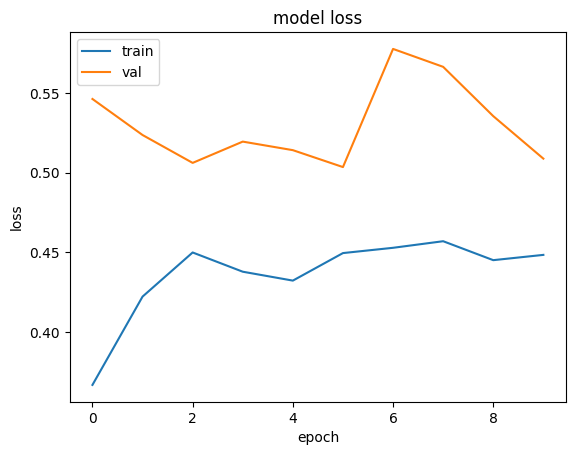

In [140]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [144]:
embeddings = model.layers[2].get_weights()[0] # матрица со всеми эмбедингами

In [145]:
full_word_embeddings = np.zeros((len(tokenizer.fullword_vocab), 100)) # матрица с эмбедингами полных слов + нграммы
id2word = list(tokenizer.fullword_vocab)

for i, word in enumerate(tokenizer.fullword_vocab):
    subwords = tokenizer(word)[0]
    full_word_embeddings[i] = embeddings[[i for i in subwords]].mean(axis=0) 

In [146]:
def most_similar_ft(word, embeddings, tokenizer):
    subwords = tokenizer(word)[0]
    word_embedding = embeddings[[i for i in subwords]].sum(axis=0)
    # idxs = [tokenizer.word2id[i] for i in tokenizer.fullword_vocab]
    similar = [id2word[i] for i in 
               cosine_distances(word_embedding.reshape(1, -1), full_word_embeddings).argsort()[0][:20]]
    return similar

In [147]:
most_similar_ft('жизнь', embeddings, tokenizer)

['жизнь',
 '«жизнь',
 'жизнь»',
 'жизнью',
 'жизни»',
 'жизни',
 'жизненно',
 'жизней',
 'жизненной',
 'жизненного',
 'жизненные',
 'жизненных',
 'жизненный',
 'жирным',
 'собственниками',
 'внутренними',
 'предлагается',
 'казнь',
 'драго',
 'предлагает']